<a href="https://colab.research.google.com/github/cemredogan-ceng/BUSI/blob/main/busi_unet%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [12]:
!pip install segmentation-models-pytorch
!pip install --upgrade torch torchvision


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=9e94d5149b7242f96501bf73f69e69ee01761cce5d2b7c353be9d3579ae48534
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=db76eb5337d83b46f66790952e3f31ab86790ef34e9574f8c936cd5b7a3e8499
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [13]:
import segmentation_models_pytorch as smp


In [20]:
!pip install segmentation-models-pytorch
!pip install --upgrade torch torchvision


Mounted at /content/drive


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:08<00:00, 31.9MB/s]


Epoch 1/50, Loss: 0.8995264259780326
Epoch 2/50, Loss: 0.7924286621372875
Epoch 3/50, Loss: 0.7220138834743965
Epoch 4/50, Loss: 0.678209184146509
Epoch 5/50, Loss: 0.638688664610793
Epoch 6/50, Loss: 0.6000890804500114
Epoch 7/50, Loss: 0.5706408888828464
Epoch 8/50, Loss: 0.5459414306210308
Epoch 9/50, Loss: 0.5322159623227468
Epoch 10/50, Loss: 0.5000765069228846
Epoch 11/50, Loss: 0.4669951920102282
Epoch 12/50, Loss: 0.46408950773681085
Epoch 13/50, Loss: 0.45653635990328906
Epoch 14/50, Loss: 0.4278913394707005
Epoch 15/50, Loss: 0.4109775940092599
Epoch 16/50, Loss: 0.4182279735076718
Epoch 17/50, Loss: 0.4042840672702324
Epoch 18/50, Loss: 0.38686369686591915
Epoch 19/50, Loss: 0.37547158104617423
Epoch 20/50, Loss: 0.3781028455350457
Epoch 21/50, Loss: 0.36188455616555565
Epoch 22/50, Loss: 0.34937970376596217
Epoch 23/50, Loss: 0.34458393294636797
Epoch 24/50, Loss: 0.3454579478356896
Epoch 25/50, Loss: 0.33423667055804557
Epoch 26/50, Loss: 0.34780079053669444
Epoch 27/50, L

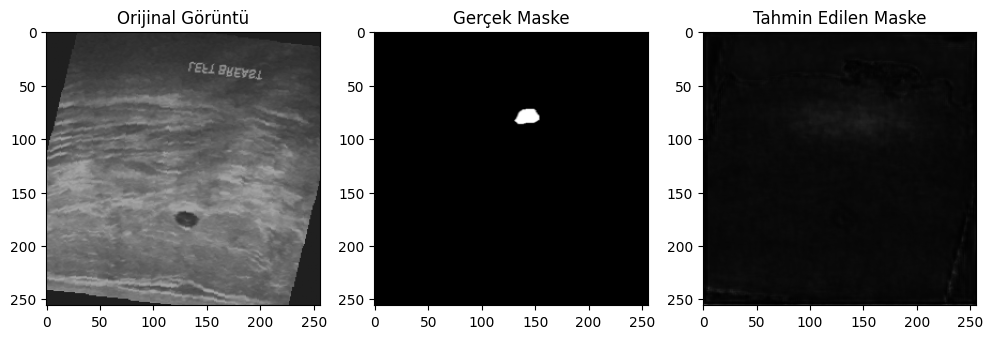

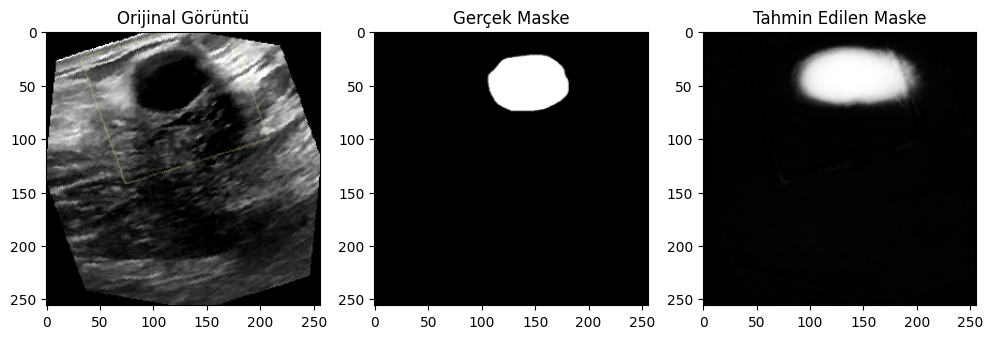

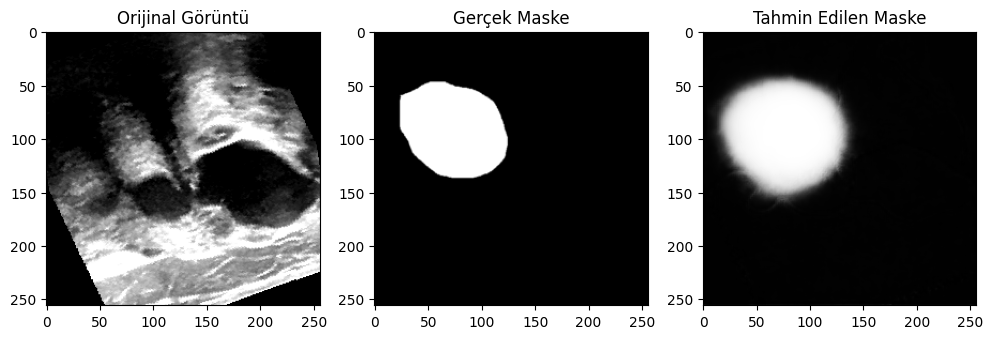

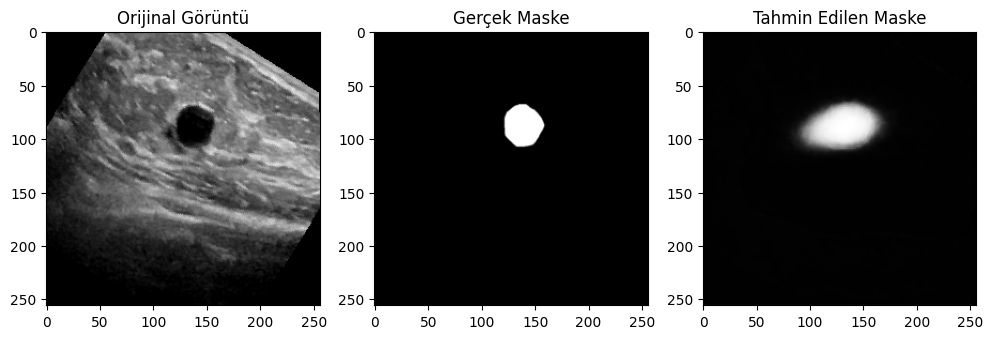

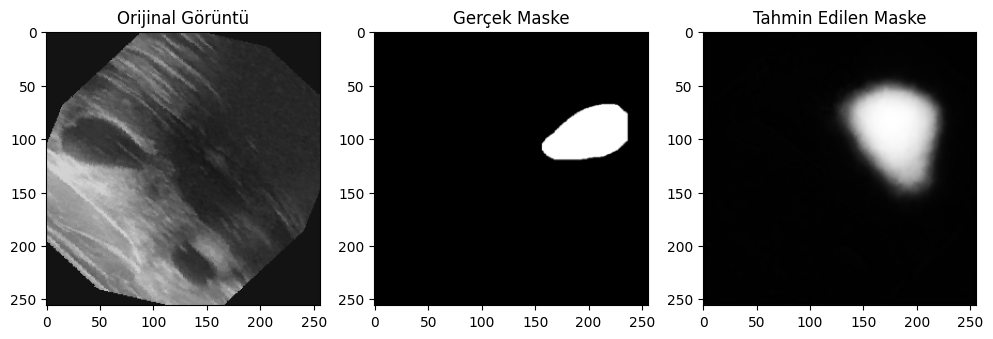

Doğrulama Metrikleri:
  Dice Skoru: 0.7779
  IOU (Intersection over Union): 0.6365


In [22]:
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Google Drive'ı bağlama
drive.mount('/content/drive', force_remount=True)

# Dataset klasörünü tanımlama
base_dir = '/content/drive/My Drive/Dataset_BUSI_with_GT'

# Dataset için PyTorch Dataset sınıfı tanımlama
class BreastUltrasoundDataset(Dataset):
    def __init__(self, root_dir, classes=['benign', 'malignant'], transform_image=None, transform_mask=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.image_paths = []
        self.mask_paths = []

        # Sınıflar boyunca görüntü ve maske yollarını yükleme
        for cls in self.classes:
            image_dir = os.path.join(root_dir, cls)
            for filename in os.listdir(image_dir):
                if filename.endswith(".png") and "_mask" not in filename:
                    image_path = os.path.join(image_dir, filename)
                    mask_path = os.path.join(image_dir, filename.replace(".png", "_mask.png"))
                    self.image_paths.append(image_path)
                    self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Görüntü ve maske dönüşümleri
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAffine(degrees=15, shear=10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Dataset oluşturma
dataset = BreastUltrasoundDataset(
    root_dir=base_dir,
    classes=['benign', 'malignant'],
    transform_image=transform_image,
    transform_mask=transform_mask
)

# DataLoader oluşturma
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

# Model tanımlama (U-Net++)
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b7",  # Daha güçlü bir encoder
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).cuda()

# Kayıp fonksiyonları
class TverskyLoss(torch.nn.Module):
    def __init__(self, alpha=0.7, beta=0.3):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        true_pos = (inputs * targets).sum()
        false_neg = ((1 - inputs) * targets).sum()
        false_pos = (inputs * (1 - targets)).sum()

        tversky_index = (true_pos + smooth) / (true_pos + self.alpha * false_neg + self.beta * false_pos + smooth)
        return 1 - tversky_index

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.8, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

tversky_loss = TverskyLoss(alpha=0.7, beta=0.3)
focal_loss = FocalLoss(alpha=0.8, gamma=2)

def compute_loss(predictions, masks):
    loss_tversky = tversky_loss(predictions, masks)
    loss_focal = focal_loss(predictions, masks)
    return loss_tversky + loss_focal

# Optimizasyon ve Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Eğitim döngüsü
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        predictions = model(images)
        loss = compute_loss(predictions, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

# Modeli kaydetme
torch.save(model.state_dict(), '/content/drive/My Drive/Dataset_BUSI_with_GT/unetplusplus_model_optimized.pth')

# Model değerlendirme
def evaluate_model(dataset, model, num_samples=5):
    model.eval()
    for i in range(num_samples):
        image, mask = dataset[i]
        image = image.unsqueeze(0).cuda()
        with torch.no_grad():
            prediction = model(image)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())
        plt.title("Orijinal Görüntü")

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze().numpy(), cmap='gray')
        plt.title("Gerçek Maske")

        plt.subplot(1, 3, 3)
        plt.imshow(prediction, cmap='gray')
        plt.title("Tahmin Edilen Maske")
        plt.show()

# Performans metrikleri
def calculate_metrics(dataset, model, num_samples=100):
    model.eval()
    all_preds = []
    all_masks = []
    for i in range(min(num_samples, len(dataset))):
        image, mask = dataset[i]
        image = image.unsqueeze(0).cuda()
        with torch.no_grad():
            prediction = model(image)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()
            prediction_binary = (prediction > 0.5).astype(np.uint8)

        all_preds.append(prediction_binary.flatten())
        all_masks.append(mask.numpy().flatten())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_masks).astype(np.uint8)

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    dice_score = (2.0 * intersection) / (y_true.sum() + y_pred.sum() + 1e-6)
    iou = intersection / (union + 1e-6)

    print("Doğrulama Metrikleri:")
    print(f"  Dice Skoru: {dice_score:.4f}")
    print(f"  IOU (Intersection over Union): {iou:.4f}")

# Değerlendirme ve görselleştirme
evaluate_model(dataset, model)
calculate_metrics(dataset, model)

